# Exploring Overfitting in NLP

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the dataset

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2019-09-23 05:30:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.144, 2a00:1450:4017:800::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  4.00MB/s    in 59s     

2019-09-23 05:31:30 (3.88 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



## Data preprocessing and Tokenizing

In [4]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

In [5]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [6]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [7]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [8]:
print(vocab_size)
print(word_index['i'])

138251
1


## Transfer learning

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2019-09-23 05:31:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.144, 2a00:1450:4017:805::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  3.72MB/s    in 86s     

2019-09-23 05:33:12 (3.87 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [10]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

## Defining the model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13825200  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
________________________________________________________

## Training the model

In [12]:
with tf.device('/device:GPU:0'):
    history = model.fit(training_sequences, training_labels, epochs=10, validation_data=(test_sequences, test_labels), verbose=2)

Train on 144000 samples, validate on 16000 samples
Epoch 1/10
144000/144000 - 40s - loss: 0.5682 - acc: 0.6981 - val_loss: 0.5277 - val_acc: 0.7345
Epoch 2/10
144000/144000 - 35s - loss: 0.5273 - acc: 0.7326 - val_loss: 0.5153 - val_acc: 0.7411
Epoch 3/10
144000/144000 - 35s - loss: 0.5118 - acc: 0.7444 - val_loss: 0.5115 - val_acc: 0.7421
Epoch 4/10
144000/144000 - 37s - loss: 0.4999 - acc: 0.7528 - val_loss: 0.5047 - val_acc: 0.7458
Epoch 5/10
144000/144000 - 38s - loss: 0.4928 - acc: 0.7572 - val_loss: 0.5055 - val_acc: 0.7469
Epoch 6/10
144000/144000 - 38s - loss: 0.4846 - acc: 0.7613 - val_loss: 0.5059 - val_acc: 0.7491
Epoch 7/10
144000/144000 - 37s - loss: 0.4793 - acc: 0.7653 - val_loss: 0.5091 - val_acc: 0.7487
Epoch 8/10
144000/144000 - 35s - loss: 0.4741 - acc: 0.7689 - val_loss: 0.5075 - val_acc: 0.7455
Epoch 9/10
144000/144000 - 36s - loss: 0.4695 - acc: 0.7709 - val_loss: 0.5043 - val_acc: 0.7489
Epoch 10/10
144000/144000 - 36s - loss: 0.4655 - acc: 0.7737 - val_loss: 0.5

## Visualizing the result

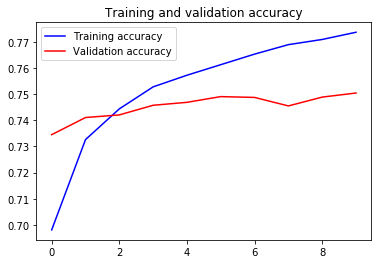

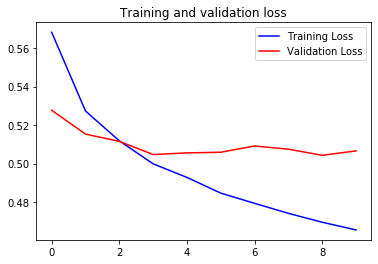

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()